## The Context

Australia has adopted an isolationist policy in response to the global coronavirus pandemic. Upon arriving in Australia, passengers are isolated in designated hotels for at least 14 days. While this process is highly effective, leaks can and do occur. Fortunately, these are regularly brought under control with effective contact tracing.

I had previously written a post applying MCMC to infer & estimate the effectiveness of different quarantine programmes. In this post, I'm going to build upon the fantastic work done by Antony Macali, who has diligently catalogued information about leaks for hotel quarantine. You can find the information he's collected [here](https://docs.google.com/spreadsheets/d/15kdyqFGfJdFi0KaTbZp-UDw8WwoKu6OPRs5V5ZzO1c0/edit#gid=0).

With this information, we can chart how effective you would have believed the quarantine system of any state was over time. It's the belief you would have had, based on the number of people successfully processed and the number of failures that occurred. 

As more infected people are successfully processed, the estimated risk falls; conversely, if there is a breach, the estimated risk immediately rises. 

To be clear, it's not a chart of how effective the system was at any point in time, just our underlying belief, based on the data we have observed, up until that point in time.


## The Model

We can build a simple but effective model by treating the number of leaks as a *binomial* variable.

We can then infer the probability each processed person results in a leak based on the number of people processed and the number of leaks observed.

We need to provide a prior estimate for the probability of processing anyone infected, resulting in a leak. A sensible estimate is that 1% of them will result in a leak. To encode this prior, I will use a *beta distribution*. 

Previously I used Markov chain Monte Carlo (MCMC) to find the posterior distribution; however, in this case, we can sidestep MCMC by taking advantage of the fact that the beta distribution is a [conjugate prior](https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading15a.pdf) of the *binomial distribution*. This means that we can algebraically find the posterior without resorting to MCMC.


Let's start by importing some useful libraries.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as st

plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.figsize"] = (15,15)

Let's load the dataset for each state from a CSV into a Pandas data frame.

In [2]:
def load_data(state):
    data_df = pd.read_csv(f'data/2021-05-02-Conjugate-Priors/COVID Live HQ Breaches - {state} 7d.csv')
    data_df['BREACH'] = data_df['BREACH'] > 0
    data_df = data_df.rename(columns={"DATE": "date", "BREACH": "breach", "OSEAS 7d AV": "avg_infections"})
    return(data_df)

This is where the magic happens.  

Looking at a slice of our dataset,

1. We define a prior probability of 1 (a) breach per 100 (b) infected people processed.
2. We find the number of infected people (N) processed by the system.
3. We find the count of the breaches (count).
4. We find the posterior probability as beta(a+count, int(b+N-count))

In [3]:
def calculate_posterior(index, a = 1, b = 100, window_size_days = 360):
    N = np.sum(data_df.avg_infections[max([0,index - window_size_days]):index])
    count = np.sum(data_df.breach[max([0,index - window_size_days]):index])
    mean =  st.beta.mean(a+count, int(b+N-count))
    interval = st.beta.interval(0.80, a+count, int(b+N-count))
    return(mean, interval)

Now it's just a matter of visualizing the results for different states.

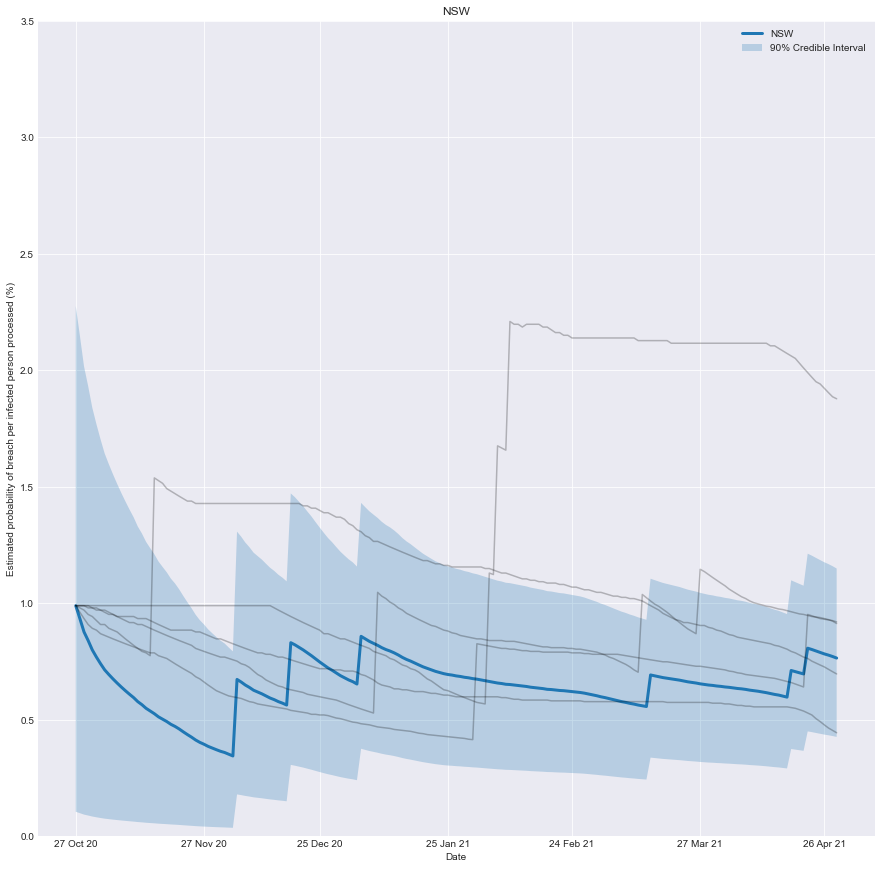

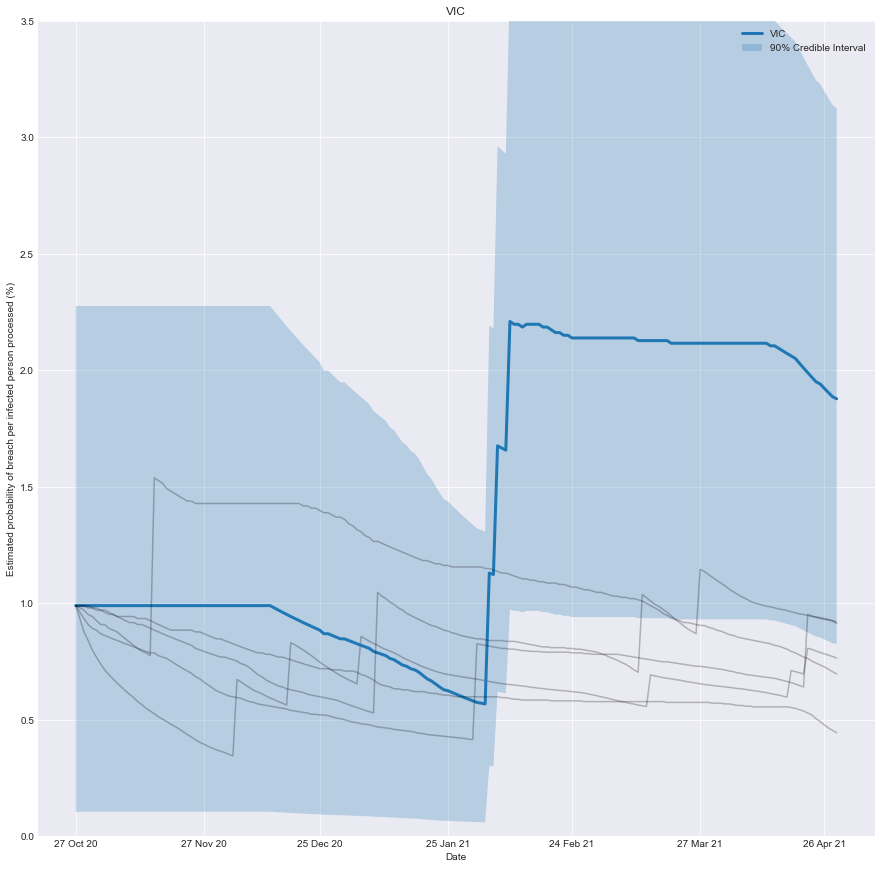

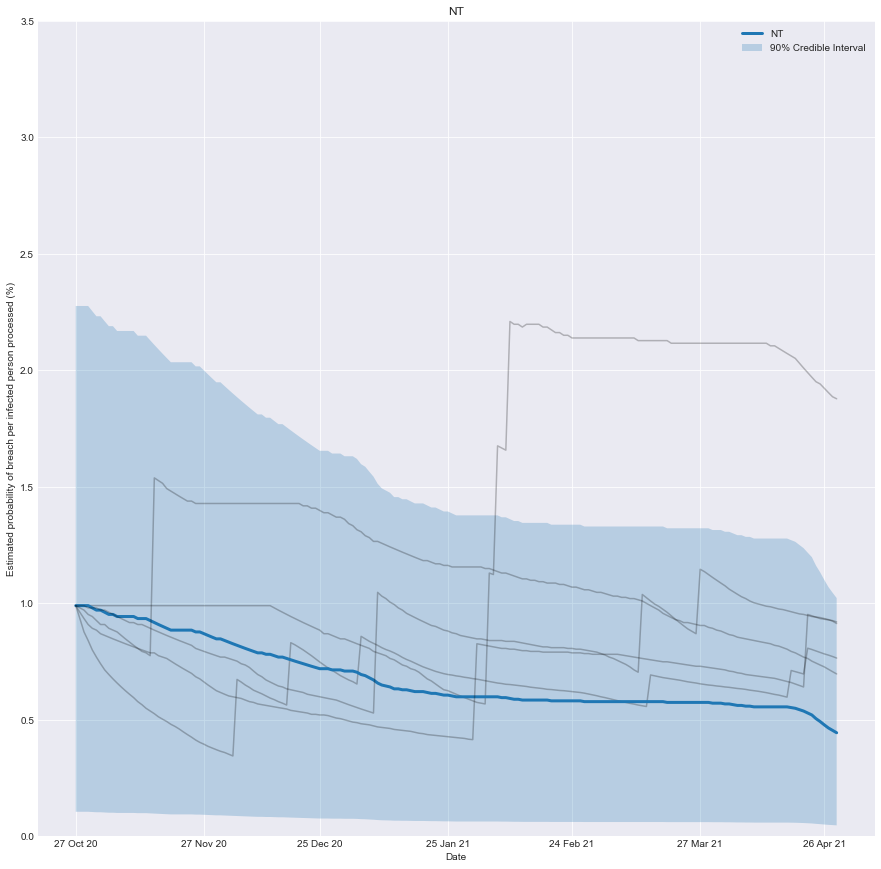

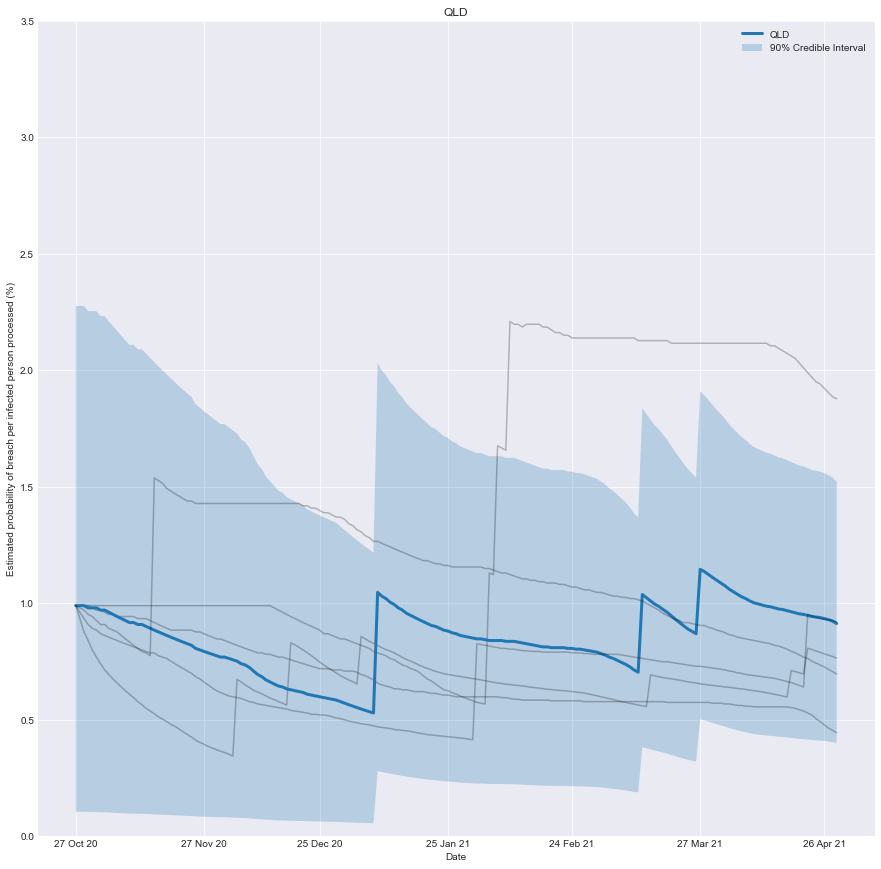

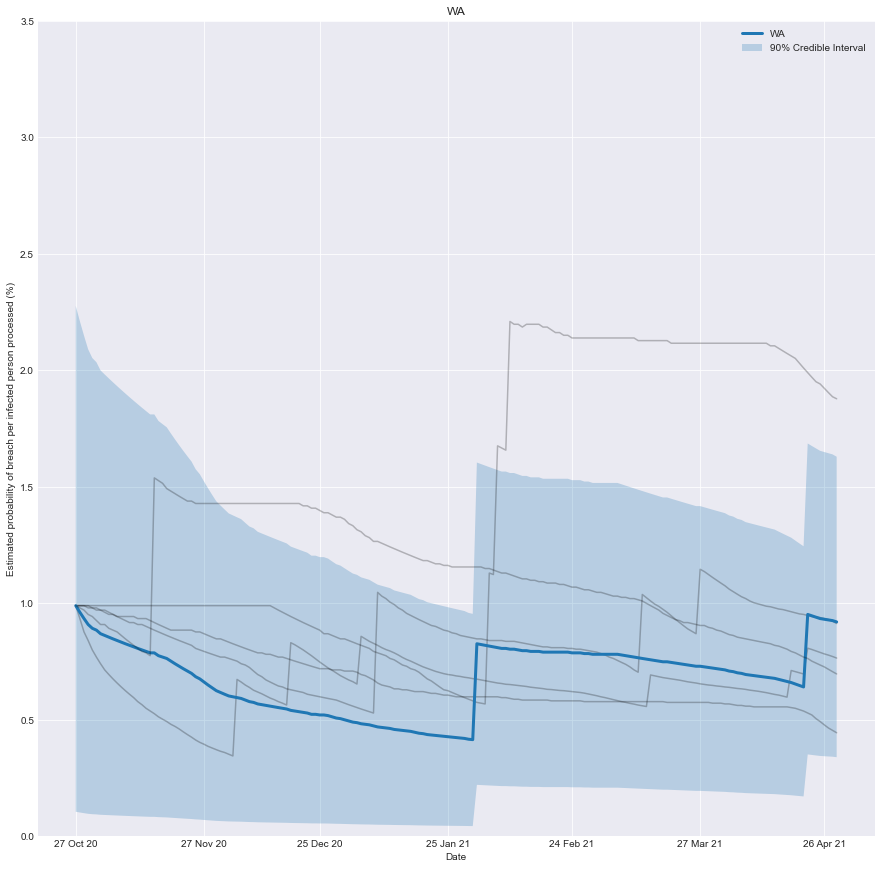

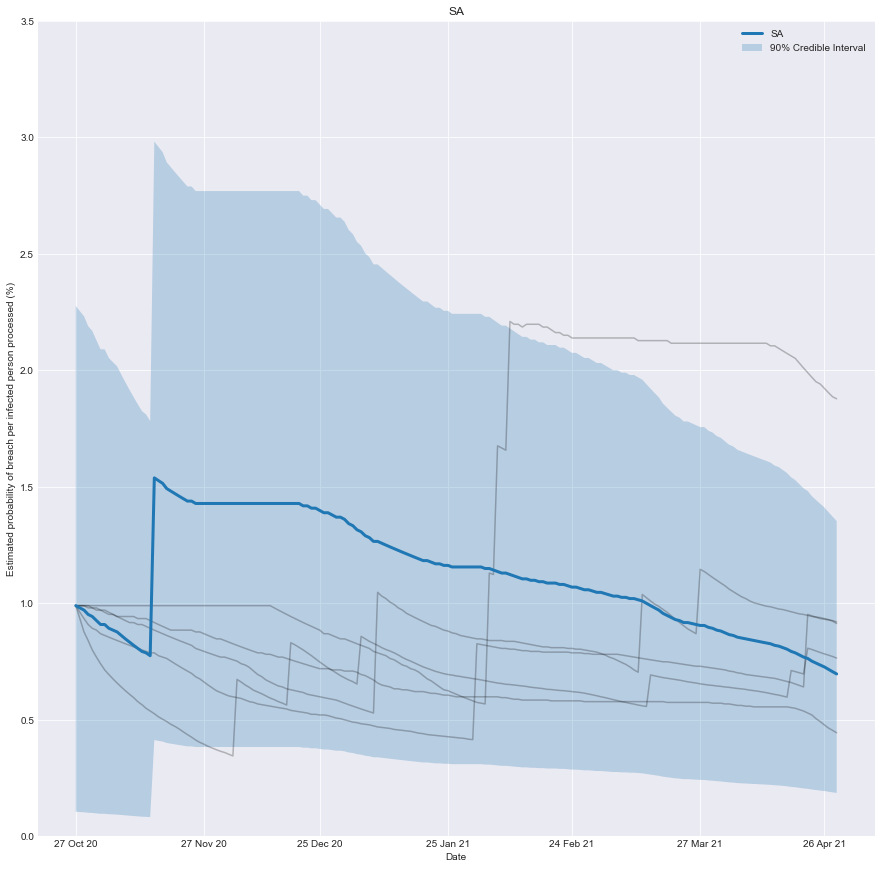

In [4]:
states = ['NSW','VIC','NT','QLD','WA', 'SA']
for target_state in states:
    fig, ax = plt.subplots()
    fmt_half_year = mdates.MonthLocator(interval=1)
    ax.xaxis.set_major_locator(fmt_half_year)
    ax.grid(True)

    for state in states:
        data_df = load_data(state)
        lowers = []
        uppers = []
        means = []
        for index in range(0, data_df.date.shape[0]):
            mean, interval = calculate_posterior(index)
            lowers.append(100 * interval[0])
            uppers.append(100 * interval[1])
            means.append(100 * mean)

        if state == target_state:
            plt.plot(data_df.date, means, label = state, linewidth = 3)
            plt.fill_between(data_df.date, lowers, uppers, label = '90% Credible Interval', alpha = 0.25)
            
        else:
            plt.plot(data_df.date, means, alpha = 0.25, color = 'k')

    plt.title(target_state)
    plt.xlabel('Date')
    plt.ylabel('Estimated probability of breach per infected person processed (%)')

    plt.ylim(0,3.5)

    plt.legend()
    plt.show()
    

## Conclusion

We can now create a real-time estimate of the probability of a breach and understand how it evolves.

As more infected people are successfully processed, the estimated risk falls; conversely, if there is a breach, the estimated risk immediately rises. 

An implicit assumption is that the underlying risk inherent in the system is static, which may not be accurate in practice as the underlying system evolves. In the case of Victoria, the troubled quarantine system has undergone two evolutions. Time and data will tell if it's 3rd time lucky.